In [11]:
import pandas as pd
import numpy as np
from datasets import Dataset

# Datatset Preparation

In [2]:
train_url= 'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv'
test_url= 'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv'

In [3]:
df_train= pd.read_csv(train_url, sep='\t', names=['sentence','label'], header=None)
df_test= pd.read_csv(test_url,  sep='\t', names=['sentence','label'], header=None)
df_train.label= df_train.label.astype(int)
df_test.label= df_test.label.astype(int)

df_train.head()

,sentence,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
df_test.head()

,sentence,label
0,"no movement , no yuks , not much of anything",0
1,"a gob of drivel so sickly sweet , even the eag...",0
2,"gangs of new york is an unapologetic mess , wh...",0
3,"we never really feel involved with the story ,...",0
4,this is one of polanski 's best films,1


In [12]:
dataset_train = Dataset.from_pandas(df_train)
dataset_test  = Dataset.from_pandas(df_test)

In [13]:
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np


train_s,val_s, train_l,val_l= train_test_split(df_train.sentence.tolist(),df_train.label.tolist(),test_size=0.2,random_state=42,stratify=df_train.label)
tokenizer= AutoTokenizer.from_pretrained('bert-base-uncased')
bert= AutoModel.from_pretrained('bert-base-uncased')
bert.eval()    
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(device)


def embed_sentences(sentences, batch_size=32):
    embeddings= []
    for start in range(0,len(sentences),batch_size):
        batch= sentences[start:start + batch_size]
        tokens= tokenizer(batch, padding=True, truncation=True,max_length=128, return_tensors='pt').to(device)
        with torch.no_grad():
            output= bert(**tokens)
            cls_embed= output.last_hidden_state[:,0,:]  # [CLS] token output

        embeddings.append(cls_embed.cpu().numpy())
    return np.vstack(embeddings)


X_train= embed_sentences(train_s,batch_size=16)
X_val= embed_sentences(val_s,batch_size=16)
X_test= embed_sentences(df_test.sentence.tolist(), batch_size=16)


y_train= np.array(train_l)
y_val= np.array(val_l)
y_test= df_test.label.values

In [25]:
from torch.utils.data import DataLoader, TensorDataset

batch_size= 32
train_ds= TensorDataset(torch.from_numpy(X_train).float(),torch.from_numpy(y_train).long())
val_ds= TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(y_val).long())
test_ds= TensorDataset(torch.from_numpy(X_test).float(),torch.from_numpy(y_test).long())

train_loader= DataLoader(train_ds,batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_ds,batch_size=batch_size)
test_loader= DataLoader(test_ds,batch_size=batch_size)

# Construct a Multi-Layer Perceptron (MLP) model.

In [26]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.hidden1= nn.Linear(input_dim, 512)
        self.act1= nn.ReLU()
        self.dropout1= nn.Dropout(0.5)
        self.hidden2= nn.Linear(512,256)
        self.act2= nn.ReLU()
        self.hidden3= nn.Linear(256,128)
        self.act3= nn.ReLU()
        self.hidden4= nn.Linear(128,64)
        self.act4= nn.ReLU()
        self.output= nn.Linear(64, num_classes)

    def forward(self, x):
        x= self.act1(self.hidden1(x))
        x= self.act2(self.hidden2(x))
        x= self.act3(self.hidden3(x))
        x= self.act4(self.hidden4(x))
        return self.output(x)


input_dim= X_train.shape[1]
model= MLP(input_dim,2)
param_count = 0

for parameter in model.parameters():
    if parameter.requires_grad:
        num_params= parameter.numel()
        param_count+= num_params
print(f"Trainable parameters: {param_count}")

Trainable parameters: 566338


# Train the model with 10 epochs and create the best-performing model (checkpoint.pt) 

In [27]:
import torch.optim as optim

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(),lr=1e-4)
best_val_acc= 0.0
history= {'epoch':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, 11):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    # validation
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss_sum += criterion(out, yb).item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

    val_acc  = correct / total
    val_loss = loss_sum / total
    history['epoch'].append(epoch)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'checkpoint.pt')

    print(f"Epoch {epoch:2d} → Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch  1 → Val Loss: 0.3712, Val Acc: 0.8396
Epoch  2 → Val Loss: 0.3558, Val Acc: 0.8454
Epoch  3 → Val Loss: 0.3404, Val Acc: 0.8504
Epoch  4 → Val Loss: 0.3325, Val Acc: 0.8504
Epoch  5 → Val Loss: 0.3484, Val Acc: 0.8533
Epoch  6 → Val Loss: 0.3319, Val Acc: 0.8533
Epoch  7 → Val Loss: 0.3235, Val Acc: 0.8605
Epoch  8 → Val Loss: 0.3434, Val Acc: 0.8555
Epoch  9 → Val Loss: 0.3354, Val Acc: 0.8656
Epoch 10 → Val Loss: 0.3561, Val Acc: 0.8432


In [28]:
# load best and test
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
test_acc = correct/total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 84.62%


/var/folders/sq/6nfr6ldx231fzstwl4xt5cs80000gn/T/ipykernel_74737/1448249633.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.

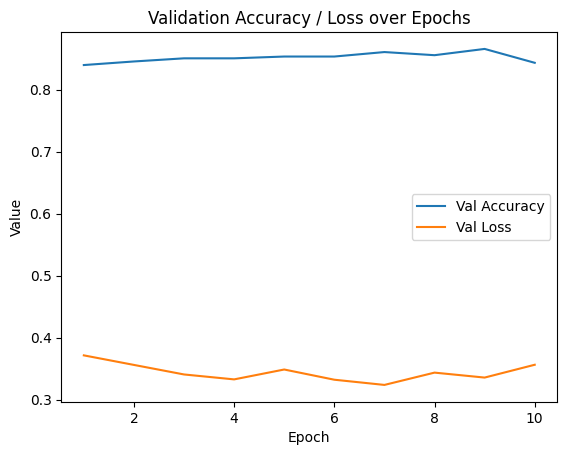

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history['epoch'], history['val_acc'], label='Val Accuracy')
plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Accuracy / Loss over Epochs')
plt.legend()
plt.show()

# Quantization

# Dynamic Quantization (INT8 via PyTorch)

In [35]:
import copy
import os
import torch
import torch.quantization
import time


orig_size= os.path.getsize('checkpoint.pt') / (1024*1024)
start= time.time()
with torch.no_grad():
    for xb, _ in test_loader:
        xb= xb.to(device)
        _ = model(xb)
orig_time= (time.time() - start)/len(test_ds)*1000 

In [36]:
torch.backends.quantized.engine = 'qnnpack'
dyn_model= torch.quantization.quantize_dynamic(
    copy.deepcopy(model), {nn.Linear}, dtype=torch.qint8
)
torch.save(dyn_model.state_dict(), 'dynamic_model.pt')
dyn_size= os.path.getsize('dynamic_model.pt') / (1024*1024)
start= time.time()
with torch.no_grad():
    for xb, _ in test_loader:
        xb= xb.to(device)
        _ = dyn_model(xb)
dyn_time= (time.time() - start)/len(test_ds) * 1000

# Half precision

In [37]:
half_model = copy.deepcopy(model).half().to(device)
torch.save(half_model.state_dict(), 'half_model.pt')
half_size = os.path.getsize('half_model.pt') / (1024*1024)
start = time.time()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device).half()
        _  = half_model(xb)
half_time = (time.time() - start) / len(test_ds) * 1000

In [38]:
results = pd.DataFrame([
    {'Model Name':'Original','Accuracy (%)': test_acc,'Storage (MB)': orig_size,'Inference Time (ms/sample)': orig_time},
    {'Model Name':'Dynamic','Accuracy (%)': test_acc,'Storage (MB)': dyn_size,'Inference Time (ms/sample)': dyn_time},
    {'Model Name':'Half','Accuracy (%)': test_acc,'Storage (MB)': half_size,'Inference Time (ms/sample)': half_time},
])

print("\nQuantization Results:")
print(results.to_string(index=False))


Quantization Results:
Model Name  Accuracy (%)  Storage (MB)  Inference Time (ms/sample)
  Original     84.623833      2.164095                    0.023021
   Dynamic     84.623833      0.549601                    0.075226
      Half     84.623833      1.083895                    0.034170
